In [1]:
#  INSTALL IMPORT LIBRARIES
!pip install bertopic[visualization] sentence-transformers pandas scikit-learn nltk --quiet
!pip install seaborn matplotlib pandas

In [2]:
# Importing Libraries
import pandas as pd
import re
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
nltk.download('punkt')

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize.punkt import PunktParameters, PunktSentenceTokenizer
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lapto\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# LOAD DATA
df = pd.read_csv("mtsamples.csv")

In [4]:
# Remove empty/missing transcriptions
df = df[df['transcription'].notnull() & (df['transcription'].str.strip() != '')]
documents = df['transcription'].tolist()

In [5]:
# INITIALIZE BERTopic
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
vectorizer_model = CountVectorizer(stop_words="english")

topic_model = BERTopic(embedding_model=embedding_model, vectorizer_model=vectorizer_model)

In [6]:
# Fit model on all documents
topics, probs = topic_model.fit_transform(documents)

In [7]:
# VIEW TOPICS + EXPORT
top_topics = topic_model.get_topic_info().head(10)
print("Top 10 Topics:")
print(top_topics)

Top 10 Topics:
   Topic  Count                                   Name  \
0     -1    582            -1_pain_patient_right_lower   
1      0    113    0_artery_coronary_french_circumflex   
2      1     89     1_stomach_esophagus_duodenum_scope   
3      2     64         2_uterine_cervix_uterus_trocar   
4      3     61         3_rotator_shoulder_cuff_tendon   
5      4     55      4_colon_sigmoid_colonoscopy_polyp   
6      5     54          5_tooth_teeth_mandible_caries   
7      6     51    6_axis_disorder_husband_psychiatric   
8      7     48         7_plantar_foot_swelling_dental   
9      8     48  8_stress_perfusion_resting_myocardial   

                                      Representation  \
0  [pain, patient, right, lower, normal, history,...   
1  [artery, coronary, french, circumflex, descend...   
2  [stomach, esophagus, duodenum, scope, hiatal, ...   
3  [uterine, cervix, uterus, trocar, curettage, p...   
4  [rotator, shoulder, cuff, tendon, glenoid, tea...   
5  [colon,

In [8]:
#  VISUALIZATIONS
topic_model.visualize_topics()       # Cluster map

In [9]:
topic_model.visualize_heatmap()      # Similarity heatmap

In [10]:
topic_model.visualize_barchart(top_n_topics=10)  # Top 10 topics bar chart

In [11]:
# TREATMENT MENTION EXTRACTION + CRITICALITY ANALYSIS

# To check the first 30
subset_df = df.head(30).copy()
subset_docs = subset_df['transcription'].tolist()

In [12]:
# Get topic and probability for subset
subset_topics, subset_probs = topic_model.transform(subset_docs)

In [13]:
# Treatment-related keyword patterns
treatment_keywords = [
    r'\bmedicat(ed|ion|ions)?\b', r'\bprescribed\b', r'\badminister(ed|ing)?\b',
    r'\bdose\b', r'\btherapy\b', r'\binjection\b', r'\bsurgery\b',
    r'\btreatment\b', r'\bprocedure\b', r'\bchemotherapy\b', r'\bradiation\b'
]

In [14]:
# Initialize sentence tokenizer manually (avoid punkt_tab error)
punkt_param = PunktParameters()
tokenizer = PunktSentenceTokenizer(punkt_param)

In [15]:
# Function to extract treatment mentions
def extract_treatments(text):
    sentences = tokenizer.tokenize(text)
    matched_sentences = [s for s in sentences if any(re.search(pat, s, re.IGNORECASE) for pat in treatment_keywords)]
    return matched_sentences if matched_sentences else ["No treatment mentioned"]

In [16]:
# Function to extract criticality score from topic probability
def get_criticality(prob):
    return float(prob) if prob is not None else 0.0

In [17]:
# Apply treatment extraction and severity scoring
subset_df['treatment_mentions'] = subset_docs
subset_df['treatment_mentions'] = subset_df['treatment_mentions'].apply(extract_treatments)
subset_df['criticality_score'] = [get_criticality(p) for p in subset_probs]
subset_df['topic'] = subset_topics

In [18]:
# Display and save
display_columns = ['description', 'treatment_mentions', 'criticality_score', 'topic']
display(subset_df[display_columns])

,description,treatment_mentions,criticality_score,topic
0,A 23-year-old white female presents with comp...,[She does have asthma but doest not require da...,0.113592,85
1,Consult for laparoscopic gastric bypass.,"[He has gastroesophageal reflux disease.,PAST ...",0.000000,-1
2,Consult for laparoscopic gastric bypass.,"[He is a diabetic, on medication., He has hemo...",0.381075,159
3,2-D M-Mode. Doppler.,[No treatment mentioned],0.244557,80
4,2-D Echocardiogram,[No treatment mentioned],0.732084,80
5,Morbid obesity. Laparoscopic antecolic anteg...,"[PREOPERATIVE DIAGNOSIS: , Morbid obesity.,POS...",1.000000,89
6,"Liposuction of the supraumbilical abdomen, re...",[The above-noted procedure was discussed with ...,0.126306,52
7,2-D Echocardiogram,[No treatment mentioned],0.679663,80
8,Suction-assisted lipectomy - lipodystrophy of...,"[PREOPERATIVE DIAGNOSIS: , Lipodystrophy of th...",0.305978,52
9,Echocardiogram and Doppler,[No treatment mentioned],0.776496,80


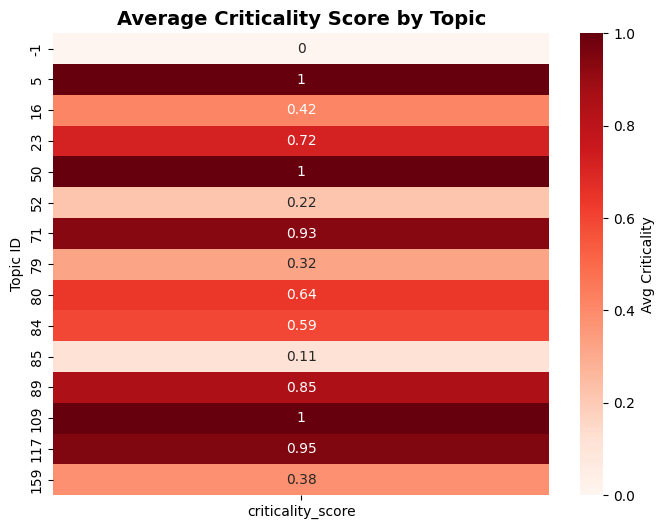

In [19]:
# Group by topic and compute average criticality
topic_group = subset_df.groupby("topic")["criticality_score"].mean().reset_index()

plt.figure(figsize=(8,6))
heatmap_data = topic_group.pivot_table(values="criticality_score", index="topic", aggfunc="mean")
sns.heatmap(heatmap_data, annot=True, cmap="Reds", cbar_kws={'label': 'Avg Criticality'})
plt.title("Average Criticality Score by Topic", fontsize=14, fontweight="bold")
plt.ylabel("Topic ID")
plt.xlabel("")
plt.show()

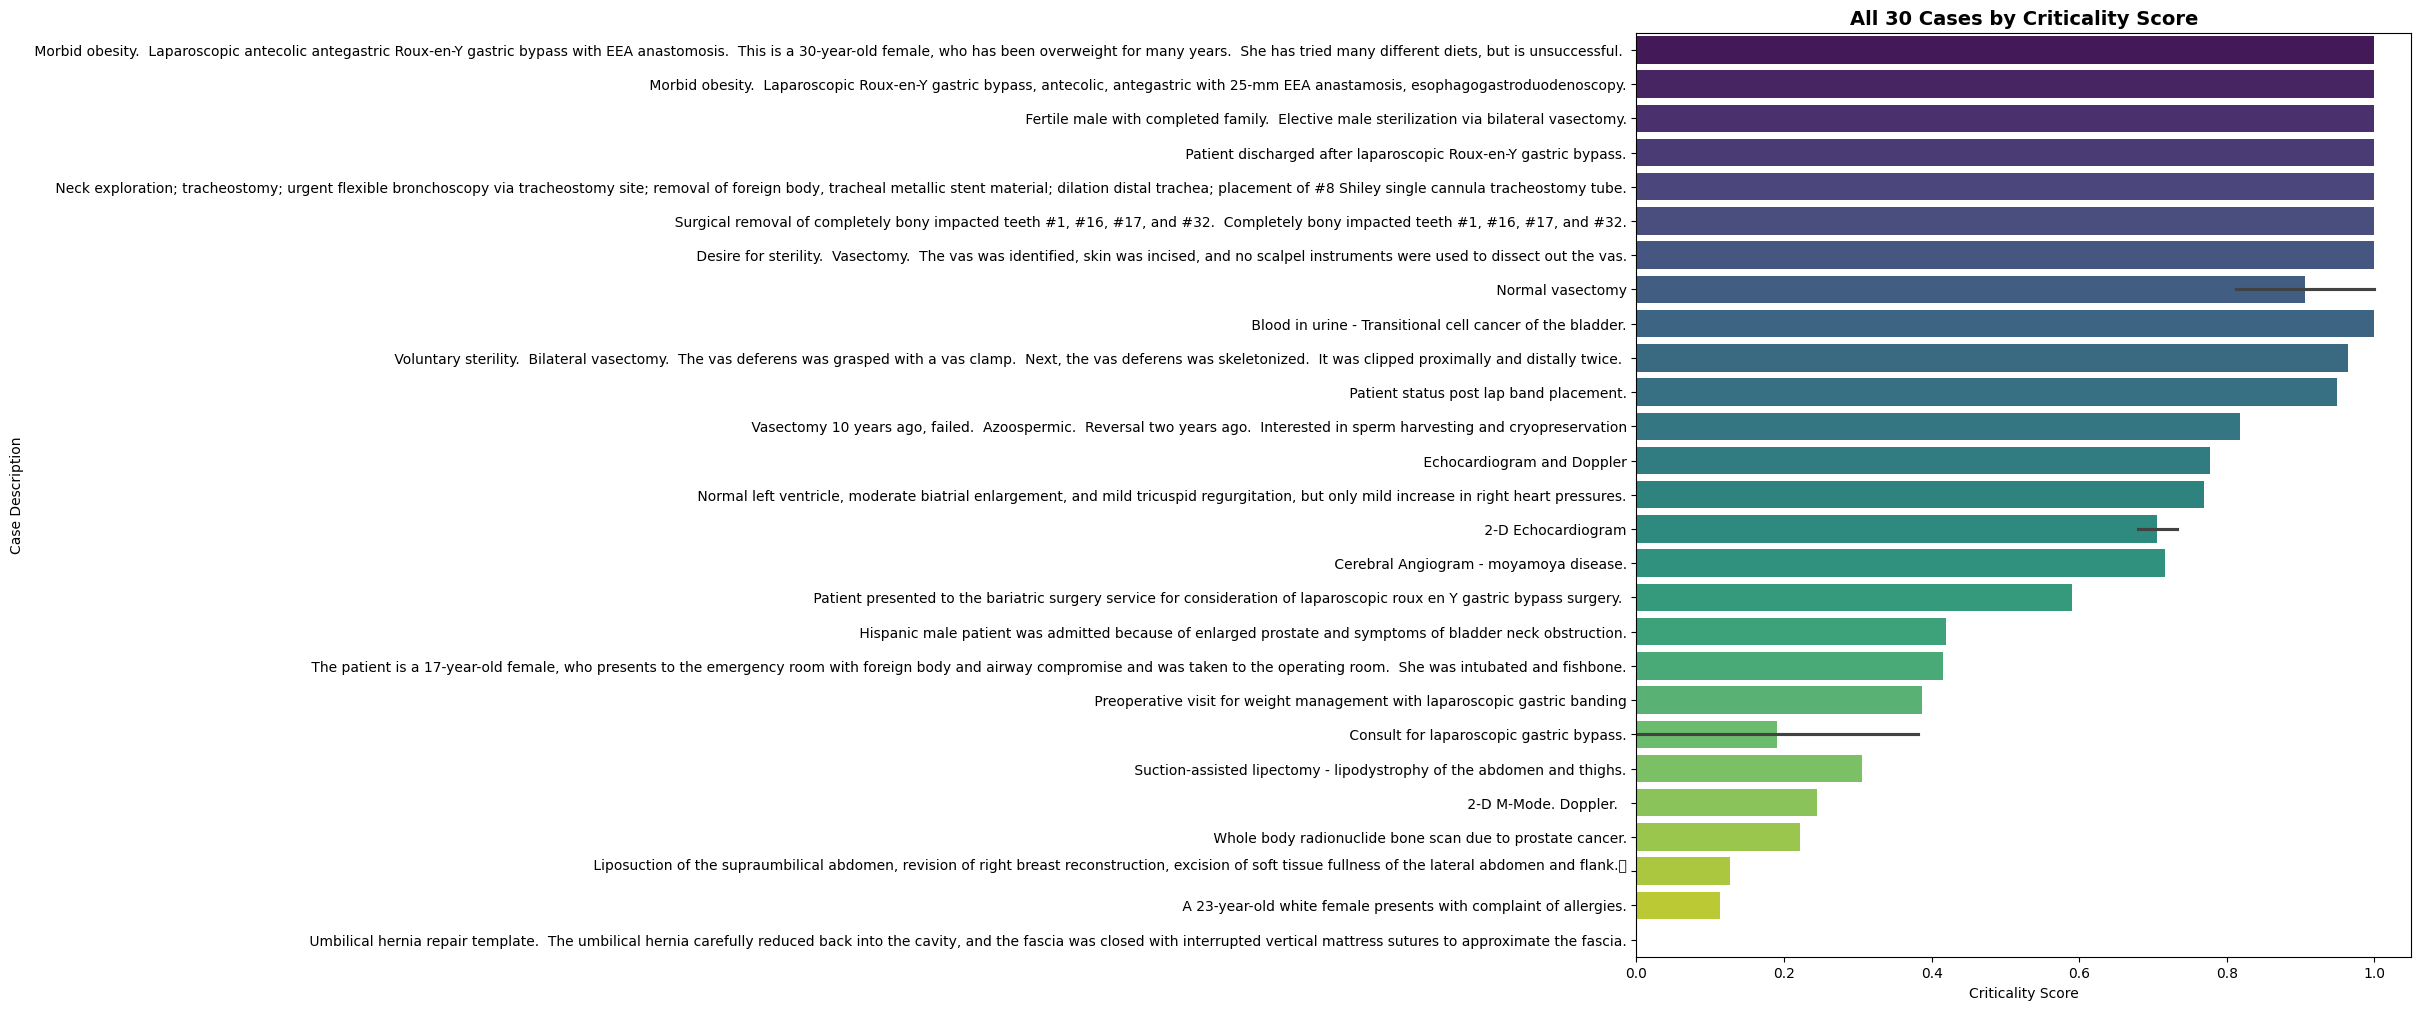

In [20]:
# Sort all 30 cases by criticality
all_cases = subset_df.sort_values(by="criticality_score", ascending=False)

plt.figure(figsize=(10,12))
sns.barplot(x="criticality_score", y="description", data=all_cases, palette="viridis")
plt.title("All 30 Cases by Criticality Score", fontsize=14, fontweight="bold")
plt.xlabel("Criticality Score")
plt.ylabel("Case Description")
plt.xlim(0,1.05)
plt.show()